In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy.ma as ma

import healpy as hp
from lsst.sims.utils import _hpid2RaDec, _approx_RaDec2AltAz
from lsst.sims.utils import Site

from astropy.time import Time, TimeDelta
import lsst.sims.seeingModel as sm

In [2]:
# Set up a SeeingModelConfig .. this could then be modified before passing to SeeingModel. 
conf = sm.SeeingModelConfig()

In [3]:
conf

lsst.sims.seeingModel.seeingModelConfig.SeeingModelConfig(telescope_seeing=0.25, optical_design_seeing=0.08, camera_seeing=0.3, raw_seeing_wavelength=500.0, filter_list=['u', 'g', 'r', 'i', 'z', 'y'], filter_effwavelens=[367.06988658, 482.68517118, 622.32403587, 754.59752265, 869.09018708, 971.02780848], throughputs_version='1.1', efd_columns=['FWHM_500'], efd_delta_time=0.0, target_columns=['airmass'])

In [6]:
# You can also check/update the effective wavelengths:
filters = ('u', 'g', 'r', 'i', 'z', 'y')
sims_photUtils_version, throughputs_version, effwavelens = sm.get_effwavelens(filters)
print(sims_photUtils_version, throughputs_version)
print(list(zip(filters, effwavelens)))

2.5.0.sims 1.5
[('u', 368.48332642306536), ('g', 480.19980829214086), ('r', 623.1199855290156), ('i', 754.1691936287622), ('z', 869.0469808767107), ('y', 973.6408690453528)]


In [7]:
conf.filter_list = filters
conf.throughputs_version = throughputs_version
conf.filter_effwavelens = effwavelens

In [8]:
# Set up and configure the SeeingModel. (note that configure with no kwarg will just use defaults, as above)
seeingModel = sm.SeeingModel(conf)   #  equivalent to seeingModel = sm.SeeingModel() when using defaults

In [9]:
# Dump the config properties and version info.
seeingModel.config_info()

OrderedDict([('SeeingModel_version', 'unknown'),
             ('SeeingModel_sha', '1db5f7a73eaa9568e187e8fe8926e854c91aaad3 *'),
             ('telescope_seeing', 0.25),
             ('optical_design_seeing', 0.08),
             ('camera_seeing', 0.3),
             ('raw_seeing_wavelength', 500.0),
             ('filter_list', ['u', 'g', 'r', 'i', 'z', 'y']),
             ('filter_effwavelens',
              [368.48332642306536, 480.19980829214086, 623.1199855290156, 754.1691936287622, 869.0469808767107, 973.6408690453528]),
             ('throughputs_version', '1.5'),
             ('efd_columns', ['FWHM_500']),
             ('efd_delta_time', 0.0),
             ('target_columns', ['airmass'])])

In [10]:
# Find the values the SeeingModel wants from the EFD. 
cols, deltaT = seeingModel.efd_requirements
print(cols, deltaT)
# Find the columns the SeeingModel wants in its input map (over which to calculate the seeing values)
print(seeingModel.target_requirements)

['FWHM_500'] 0.0
['airmass']


In [11]:
# Set up to get seeingData from db..  (this is where EFD would step in, in future)
t = Time('2002-01-01', scale='utc', format='isot')

seeingData = sm.SeeingData(t)
seeingData.read_data()

In [27]:
# Take a quick peek at the FWHM_500 values throughout the lifetime of the survey. 
# (remember that the current DB repeats after a few years)
t_end = (3650) * 24 * 60 * 60  # seconds
t_step = 30000
times = np.arange(0, t_end + t_step/2, t_step)
fwhm_500 = np.zeros(len(times), float)
for i, t_add in enumerate(times):
    t_now = t + TimeDelta(t_add, format='jd')
    fwhm_500[i] = seeingData(t_now)

Text(0, 0.5, 'FWHM_500')

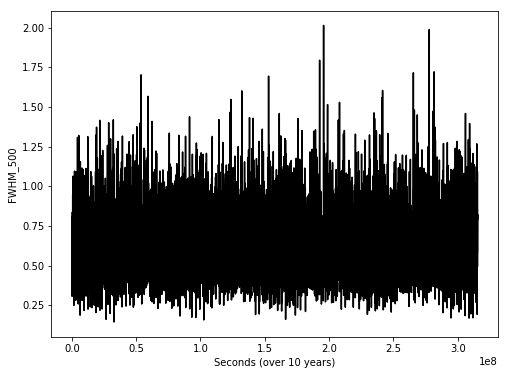

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(times, fwhm_500, 'k-')
plt.xlabel('Seconds (over 10 years)')
plt.ylabel('FWHM_500')

Text(0, 0.5, 'Airmass')

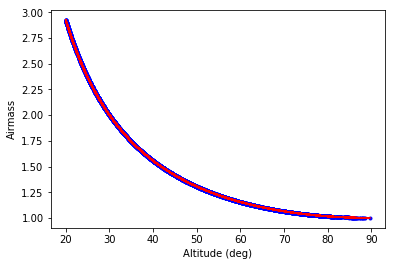

In [29]:
# Set up grid around sky .. (places we'd be likely to calculate the FWHM_eff in the FBS)
lsst_site = Site('LSST')
nside = 32
hpid = np.arange(hp.nside2npix(nside))
ra, dec = _hpid2RaDec(nside, hpid)
alt, az = _approx_RaDec2AltAz(ra, dec, lsst_site.latitude_rad, lsst_site.longitude_rad, t.mjd)

# If we set the mask here - it propagates. 
mask = np.where(alt < np.radians(20), True, False)
visible = np.where(alt > np.radians(20))
airmass = 1./np.cos(np.pi/2. - alt)

# I wonder if masked arrays makes this calculation faster? (Is it skipping the masked pixels?)
# ... output of next two cells says no, Masked Arrays are markedly slower!
# best way is to use a boolean mask? 

altM = ma.MaskedArray(data=alt, mask=mask, fill_value=0)
airmassM = 1./np.cos(np.pi/2. - altM)

plt.plot(np.degrees(alt[visible]), airmass[visible], 'b.')
plt.plot(np.degrees(altM), airmassM, 'r')
plt.xlabel('Altitude (deg)')
plt.ylabel('Airmass')

In [30]:
%%timeit 
# Full calculation
airmass = 1./np.cos(np.pi/2. - alt)

77.4 µs ± 184 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [31]:
%%timeit
# calculation with masked arrays
airmassM = 1./np.cos(np.pi/2. - altM)

366 µs ± 4.26 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [32]:
%%timeit
# calculation with mask, although making 'airmass' array each time.
airmass = np.zeros(len(alt), float)
airmass[visible] = 1./np.cos(np.pi/2. - alt[visible])

66.2 µs ± 718 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [33]:
airmass = np.zeros(len(alt), float)

In [34]:
%%timeit
# calculation with mask, using preallocated 'airmass' array
airmass[visible] = 1./np.cos(np.pi/2. - alt[visible])

59.6 µs ± 626 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [35]:
fwhm_500 = seeingData(t_now)
print(fwhm_500)

0.794677972793579


In [36]:
# Put input telemetry and target map into dictionaries:
mapDict = {'airmass': airmass}
mapDictMask = {'airmass': airmass[visible]}
efdDict = {'FWHM_500': fwhm_500}

In [37]:
%%timeit
# Check time to calculate seeing. No mask. 
modelDict = seeingModel(efdDict, mapDict)
fwhm_eff = modelDict['fwhmEff']
fwhm_geom = modelDict['fwhmGeom']

915 µs ± 26.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [38]:
%%timeit
# Check time to calculate seeing. WITH mask.
fwhm_eff = np.zeros((len(seeingModel.filter_list), len(airmass)), float)
fwhm_geom = np.zeros((len(seeingModel.filter_list), len(airmass)), float)
#print(fwhm_eff[:, visible[0]].shape)
modelDict = seeingModel(efdDict, mapDictMask)
fwhm_eff[:, visible[0]] = modelDict['fwhmEff']
fwhm_geom[:, visible[0]] = modelDict['fwhmGeom']

685 µs ± 65 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [39]:
# And then what about time, if you pre-allocate arrays?
fwhm_eff = np.zeros((len(seeingModel.filter_list), len(airmass)), float)
fwhm_geom = np.zeros((len(seeingModel.filter_list), len(airmass)), float)

In [40]:
%%timeit
modelDict = seeingModel(efdDict, mapDictMask)
fwhm_eff[:, visible[0]] = modelDict['fwhmEff']
fwhm_geom[:, visible[0]] = modelDict['fwhmGeom']

688 µs ± 82.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [41]:
# Loop over a bunch of times and calculate values.. (maybe what you'd do in the driver)
t_end = 10 * 60 * 60  # seconds
t_step = 30 # seconds
times = np.arange(0, t_end + t_step/2, t_step)
fwhm_500 = np.zeros(len(times), float)
fwhm_eff = np.zeros((len(seeingModel.filter_list), len(airmass)), float)
fwhm_geom = np.zeros((len(seeingModel.filter_list), len(airmass)), float)
for i, t_add in enumerate(times):
    t_now = t + TimeDelta(t_add, format='jd')
    fwhm_500[i] = seeingData(t_now)
    modelDict = seeingModel({'FWHM_500': fwhm_500[i]}, mapDictMask)
    fwhm_eff[:, visible[0]] = modelDict['fwhmEff']
    fwhm_geom[:, visible[0]] = modelDict['fwhmGeom']

In [42]:
for f, fwhmEff in zip(seeingModel.filter_list, fwhm_eff):
    print(f, fwhmEff[visible])

u [3.05064754 3.02053823 2.99929678 ... 2.45336694 2.50024598 2.41965205]
g [2.83751269 2.80950698 2.78974957 ... 2.28196136 2.32556517 2.25060198]
r [2.64514959 2.61904247 2.60062447 ... 2.12726067 2.16790846 2.09802723]
i [2.51442215 2.48960528 2.47209753 ... 2.02212811 2.06076703 1.99433944]
z [2.42260403 2.39869339 2.38182496 ... 1.94828689 1.98551484 1.92151296]
y [2.35212588 2.32891085 2.31253316 ... 1.89160753 1.92775245 1.86561251]
